In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [3]:
S8_initial_g = 2.6565990721396795
S6_initial_g = 0.03308746536461487
S4_initial_g = 0.013008078277994115
S2_initial_g = 2.8449317677625998e-08
S1_initial_g = 4.404388467562549e-12
Sp_initial_g = 2.6636551382083317e-06

# the total active material mass
m_s = S8_initial_g + S6_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S6_initial_frac = S6_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168*1.5

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt*3
S6_initial_hunt = S6_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

model = pybamm.lithium_sulfur.Cornish_pseudospatial()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds = 12800#18310#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4]*10,
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 50,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 25000,
        "kappa" : 15,
        "Ambient Temperature [K]":312,
        #"S saturation mass [g]": 1e-3,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_cornish_312 = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_cornish_312.solve(np.linspace(0, time_in_seconds, 10000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

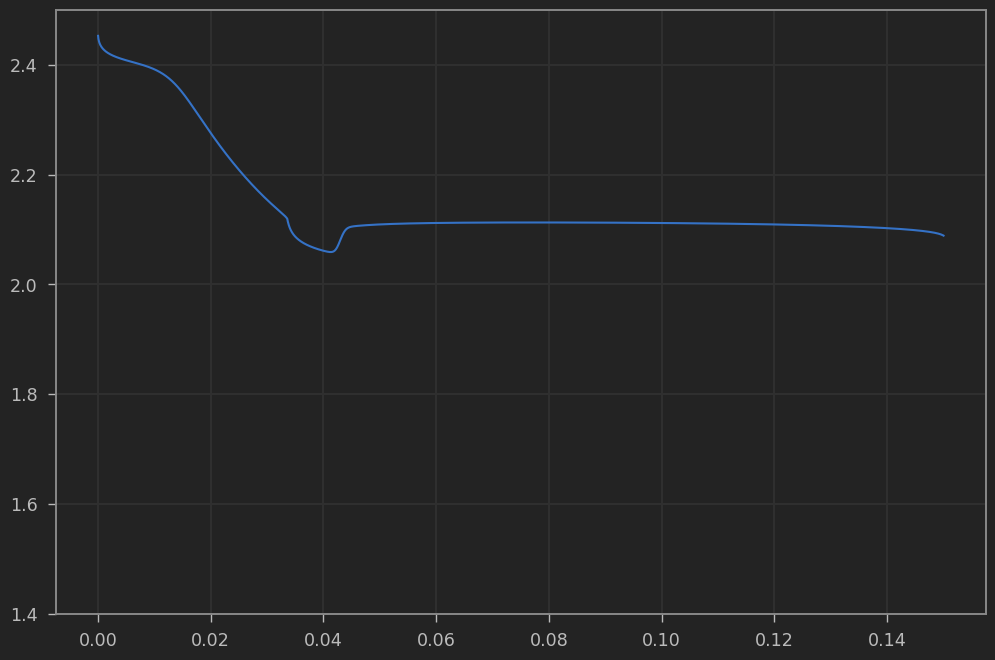

In [4]:
voltage_cornish_312 = sim_cornish_312.solution['Terminal voltage [V]'].entries
capacity_cornish_312 = abs(current)*sim_cornish_312.solution.t/3600
plt.plot(capacity_cornish_312,voltage_cornish_312)
plt.ylim([1.4,2.5])
plt.grid(True)
notify

In [5]:
S8_initial_g = 2.6565990721396795
S6_initial_g = 0.03308746536461487
S4_initial_g = 0.013008078277994115
S2_initial_g = 2.8449317677625998e-08
S1_initial_g = 4.404388467562549e-12
Sp_initial_g = 2.6636551382083317e-06

# the total active material mass
m_s = S8_initial_g + S6_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S6_initial_frac = S6_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168*1.5

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt*3
S6_initial_hunt = S6_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

model = pybamm.lithium_sulfur.Cornish_pseudospatial()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds = hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4]*10,
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 50,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 25000,
        "kappa" : 15,
        "Ambient Temperature [K]":302,
        #"S saturation mass [g]": 1e-3,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_cornish_302 = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_cornish_302.solve(np.linspace(0, time_in_seconds, 100000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

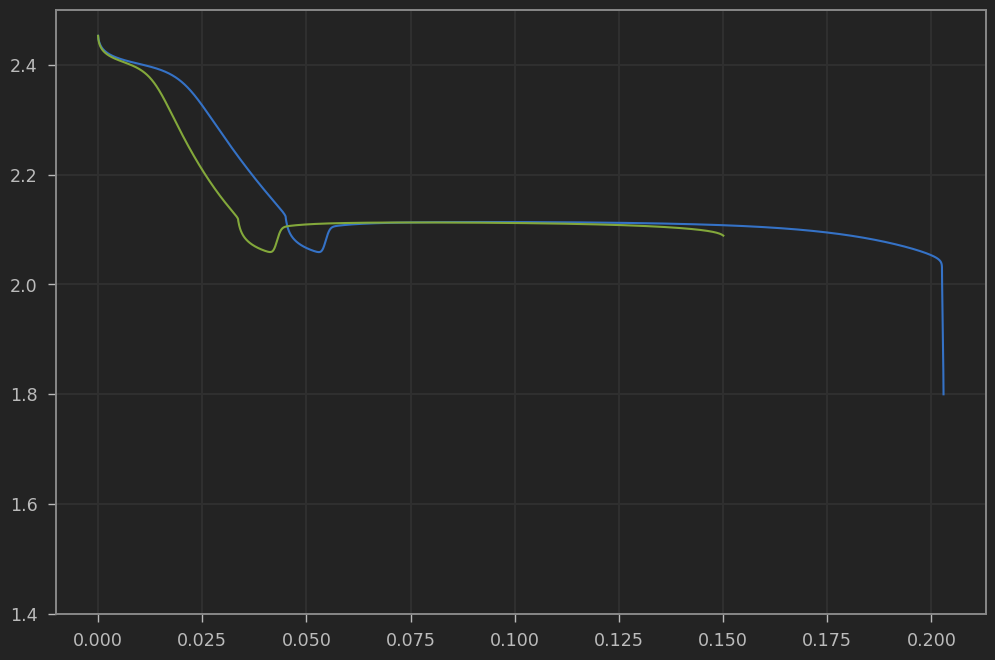

In [6]:
voltage_cornish_302 = sim_cornish_302.solution['Terminal voltage [V]'].entries
capacity_cornish_302 = abs(current)*sim_cornish_302.solution.t/3600
plt.plot(capacity_cornish_302,voltage_cornish_302)

voltage_cornish_312 = sim_cornish_312.solution['Terminal voltage [V]'].entries
capacity_cornish_312 = abs(current)*sim_cornish_312.solution.t/3600
plt.plot(capacity_cornish_312,voltage_cornish_312)
plt.ylim([1.4,2.5])
plt.grid(True)
notify

In [ ]:
S6 = sim_cornish_302.solution['S6 [g]'].entries
S4 = sim_cornish_302.solution['S4 [g]'].entries
S2 = sim_cornish_302.solution['S2 [g]'].entries
S1 = sim_cornish_302.solution['S [g]'].entries

plt.plot(capacity_cornish_302,S6)
plt.plot(capacity_cornish_302,S4)
plt.plot(capacity_cornish_302,S2)
plt.plot(capacity_cornish_302,S1)

In [ ]:
S6 = sim_cornish_312.solution['S6 [g]'].entries
S4 = sim_cornish_312.solution['S4 [g]'].entries
S2 = sim_cornish_312.solution['S2 [g]'].entries
S1 = sim_cornish_312.solution['S [g]'].entries

plt.plot(capacity_cornish_312,S6)
plt.plot(capacity_cornish_312,S4)
plt.plot(capacity_cornish_312,S2)
plt.plot(capacity_cornish_312,S1)